<a href="https://colab.research.google.com/github/wentao0420/IANNwTF_Group40/blob/main/IANNwTF_week8_Group40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **2 Assignment: Autoencoders**

---

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime as datetime
from keras import backend as K
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import seaborn as sns

Load the dataset

In [ ]:
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## **2.1 Prepare the dataset**

---

In [ ]:
# Introduce a hyperparameter to control how noisy the data will be
mean = 0.5
stddev = 0.5
batchsize = 64

In [ ]:
def preprocess(ds):

    # Normalize the images and make sure that you have sensible dimensions
    ds = ds.map(lambda x, _: (tf.cast(x, tf.float32), tf.cast(x, tf.float32)))
    ds = ds.map(lambda x, t: ((x/128.)-1., (t/128.)-1))

    for x, _ in ds.take(1):
        img_shape = x.shape

    # Add noise to your input images
    noise_factor = 0.5
    noise = noise_factor*tf.random.normal(shape=img_shape, mean=mean, stddev=stddev, dtype=tf.dtypes.float32)
    ds = ds.map(lambda x, t: (x + noise, t))
    ds = ds.map(lambda x, t: (tf.clip_by_value(x, clip_value_min=-1, clip_value_max=1), t)) # shape=(28, 28, 1, 1)

    # Cache, shuffle, batch, prefetch
    ds = ds.cache()
    ds = ds.shuffle(1000)
    ds = ds.batch(batchsize)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds
  
noisy_train_ds = preprocess(train_ds)
noisy_test_ds = preprocess(test_ds)

# Suggestion from other group
# Visualize the input and noisy target image
# Get the first element in the dataset
noisy_image, original_image = next(iter((noisy_train_ds.take(1))))

## **2.2 The model**

---

Implement a convolutional autoencoder.


**2.2.1 Convolutional Autoencoder**

---

In [ ]:
embedding = 10
zmean = tf.keras.layers.Dense(embedding)
zlogvar = tf.keras.layers.Dense(embedding)

Encoder: The encoder should reduce the size of feature maps like a CNN. At the end of the encoder, flatten the feature maps and use a dense layer to produce an embedding of a certain size.

In [ ]:
class encoder(tf.keras.Model):
    def __init__(self, embedding=embedding, vae=False):
        super(encoder, self).__init__()

        self.vae = vae

        self.convlayer1 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', strides=2) 
        self.convlayer2 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', strides=2)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()

        # flatten the feature maps and use a dense layer to produce an embedding of a certain size
        self.flatten =  tf.keras.layers.Flatten()

        if vae == True:
            self.z_mean = zmean
            self.z_log_var = zlogvar

            def sampling(args):
                z_mean, z_log_var = args
                epsilon = K.random_normal(shape=(K.shape(z_mean)[0], embedding), mean=0., stddev=0.1)
                return z_mean + K.exp(z_log_var) * epsilon

            self.output_layer = tf.keras.layers.Lambda(sampling)

        else: 
            self.output_layer = tf.keras.layers.Dense(embedding, activation='relu')

    def __call__(self, input):
        x = self.convlayer1(input)
        x = self.batchnorm1(x)
        x = self.convlayer2(x)
        x = self.flatten(x)

        if self.vae == True:
            z_mean = self.z_mean(x)
            z_log_var = self.z_log_var(x)
            x = self.output_layer(([z_mean, z_log_var]))
        
        else:
            x = self.output_layer(x)

        return x

Decoder: The decoder takes the embedding from the encoder as input. Use a dense layer to restore the dimensionality of the flattened feature maps from the encoder and reshape the resulting vector into feature maps again. Use upsampling or transposed convolutions to mirror your encoder. As an output layer, use a convolutional layer with one filter and sigmoid activation to produce an output image.

In [ ]:
class decoder(tf.keras.Model):
    def __init__(self):
        super(decoder, self).__init__()

        # Use a dense layer to restore the dimensionality of the flattened feature maps from the encoder
        self.restore_di_layer = tf.keras.layers.Dense(784, activation='sigmoid')

        # Reshape the resulting vector into feature maps
        self.reshape_layer = tf.keras.layers.Reshape((28, 28, 1)) 

        # Use upsampling or transposed convolutions to mirror the encoder
        self.convTlayer1 = tf.keras.layers.Conv2DTranspose(filters=48, kernel_size=3, padding='same', activation='relu', strides=1) 
        self.convTlayer2 = tf.keras.layers.Conv2DTranspose(filters=48, kernel_size=3, padding='same', activation='relu', strides=1) 
        self.batchnorm1 = tf.keras.layers.BatchNormalization()  

        # As an output layer, use a convolutional layer with one filter and sigmoid activation to produce an output image
        self.output_layer = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', strides=1, activation='sigmoid')

    def __call__(self, input):
            x = self.restore_di_layer(input)
            x = self.reshape_layer(x)
            x = self.convTlayer1(x) 
            x = self.convTlayer2(x)
            x = self.batchnorm1(x)
            x = self.output_layer(x)

            return x

In [ ]:
class autoencoder(tf.keras.Model): 
    def __init__(self, vae=False):
        super(autoencoder, self).__init__()

        self.encoder = encoder(embedding=embedding, vae=vae)
        self.decoder = decoder()

    def __call__(self, input, training=False):
        
        encoded = self.encoder(input)
        decoded = self.decoder(encoded) 
        
        return decoded

## **2.3 Training**

---

In [ ]:
epochs = 2
learning = 1e-3

autoencoder_model = autoencoder(vae=False)

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate = learning)

In [ ]:
EXPERIMENT_NAME = "Autoencoder"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{EXPERIMENT_NAME}/{current_time}")

autoencoder_model.compile(loss = loss, optimizer = optimizer)

history = autoencoder_model.fit(noisy_train_ds, validation_data = noisy_test_ds, epochs=epochs, callbacks = [logging_callback])

Epoch 1/2
938/938 [==============================] - 22s 14ms/step - loss: 0.9311 - val_loss: 0.9243
Epoch 2/2
938/938 [==============================] - 8s 8ms/step - loss: 0.9239 - val_loss: 0.9243


## **2.4 Latent Space Analysis**

---
Embed the first 1000 images of the test set using the encoder. Reduce the dimensionality of the embeddings to two using the t-SNE algorithm. Then plot the data points, coloured according to their class. Evaluate the result. Further, interpolate linearly between the embeddings of two images and plot the reconstructed images.

**We got help from other group.**

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


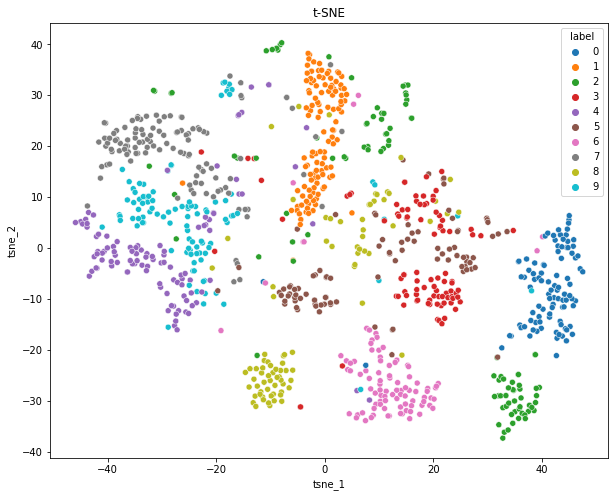

In [ ]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

# Embed the first 1000 images of the test set
X = X[:1000]

# Fit and transform with a t-SNE
n_components = 2
tsne = TSNE(n_components)

# Project the data in 2D
tsne_result = tsne.fit_transform(X)
 
# Plot the result of the t-SNE with the label color coded
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y[:1000]})

plt.figure(figsize=(10,8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df)
plt.title("t-SNE")
plt.show()